In [1]:
import os, sys
sys.path.insert(0, '..')

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth'    : 0.4,
                     'ytick.major.width' : 0.4,
                     'ytick.minor.width' : 0.4,
                     'xtick.major.width' : 0.4,
                     'xtick.minor.width' : 0.4,
                     'xtick.major.size'  : 4,
                     'xtick.minor.size'  : 2,
                     'ytick.major.size'  : 4,
                     'ytick.minor.size'  : 2,
                     'xtick.minor.visible' : 'True',
                     'ytick.minor.visible' : 'True',
                     'xtick.labelsize': 8, 
                     'ytick.labelsize': 8,
                     'axes.labelsize' : 8,
                     'font.family': 'Sans Serif',
                     'figure.figsize': (3.5, 3.33),
                     'figure.dpi' : 200,
                     'ytick.right': 'True',
                     'xtick.top'  : 'True',
                     'ytick.direction': 'in',
                     'xtick.direction': 'in',
                     'axes.spines.top': 'True',
                     'axes.grid': 'False',
                     'grid.linestyle': '--',
                     'grid.linewidth': 0.10
                    })
sns.set_palette('deep')

In [279]:
from spencer2017 import *
import numpy as np

# QUICKLY generating a grid of models and evolving them for 100 epochs

In [275]:
""" USAGE """
key = random.key(42)
num_epochs = 4000
num_stars = 10000
mass = 0.8
log_g = 2.0
binary_fraction = 1.0
dt = 1
mean_vlos = 0
dispersion_vlos = 1
noise = 0.01

all_masses = jnp.array([mass]*num_stars)
all_log_g = jnp.array([log_g]*num_stars)
binary_mask   = random.bernoulli(key=key,p=binary_fraction,shape=all_masses.shape)
binary_masses = all_masses[binary_mask]
binary_log_g  = all_log_g[binary_mask]
state = generate_orbit_state(key=key,masses=binary_masses,log_g=binary_log_g)
vr = []
dt_days=jnp.array([dt]*num_epochs)

for i in range(num_epochs):
    state = binary_step(params=state.params,dt_days=dt_days[i])
    vr.append(state.v_r)
    
vr = jnp.array(vr).T # This has shape (num_binaries, num_epochs)
v_los = mean_vlos + dispersion_vlos*random.normal(key,shape=all_masses.shape)
v_los = jnp.repeat(v_los[:, jnp.newaxis], num_epochs, axis=-1)
v_los_noise = noise*random.normal(key,shape=v_los.shape)
binary_mask_expanded = jnp.repeat(binary_mask[:, jnp.newaxis], num_epochs, axis=-1)
vr = jnp.place(arr=jnp.zeros(v_los.shape), mask=binary_mask_expanded, vals=vr, inplace=False)
v_los_total = v_los + v_los_noise + vr

# Distributions for radial velocity profiles

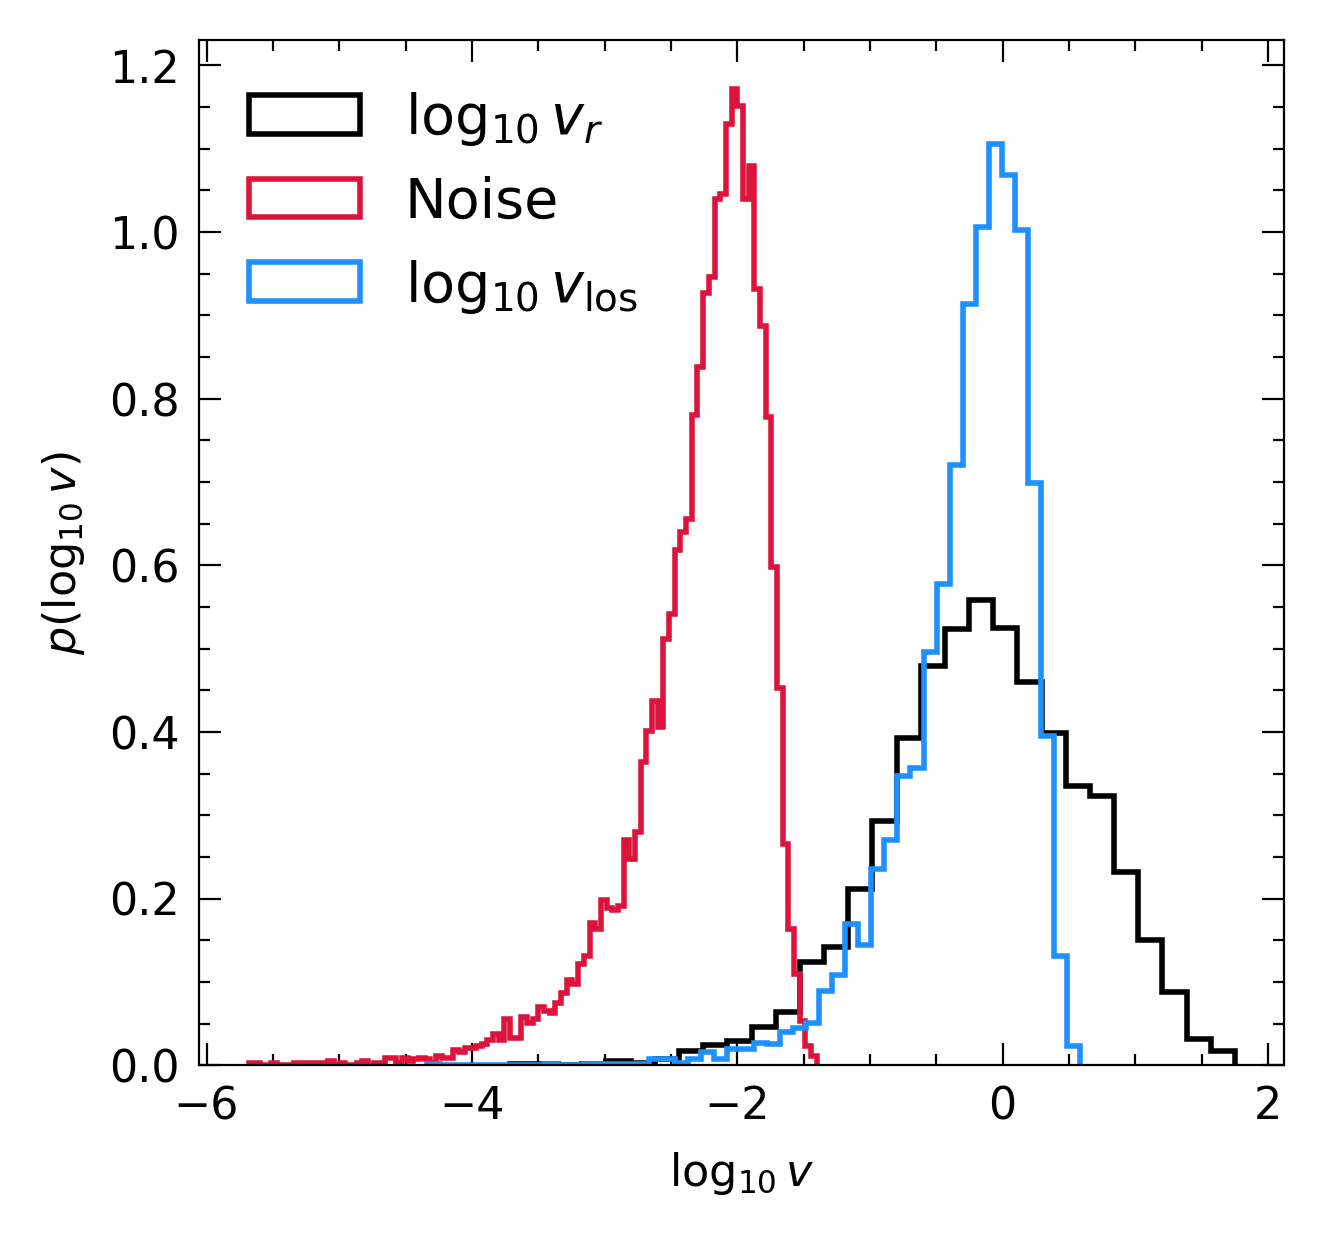

In [276]:
plt.hist(jnp.log10(jnp.abs(vr[binary_mask, 0])), bins=30, histtype='step', color='k', density=True, label=r'$\log_{10}v_r$')
plt.hist(jnp.log10(jnp.abs(v_los_noise[:,0])), density=True, histtype='step', color='crimson', bins=100, label='Noise')
plt.hist(jnp.log10(jnp.abs(v_los[:, 0])), bins=50, histtype='step', color='dodgerblue', density=True, label=r'$\log_{10}v_\mathrm{los}$')
plt.legend(frameon=False)
plt.xlabel(r'$\log_{10}v$')
plt.ylabel(r'$p(\log_{10}v)$')
plt.show()

# RV curve inspection

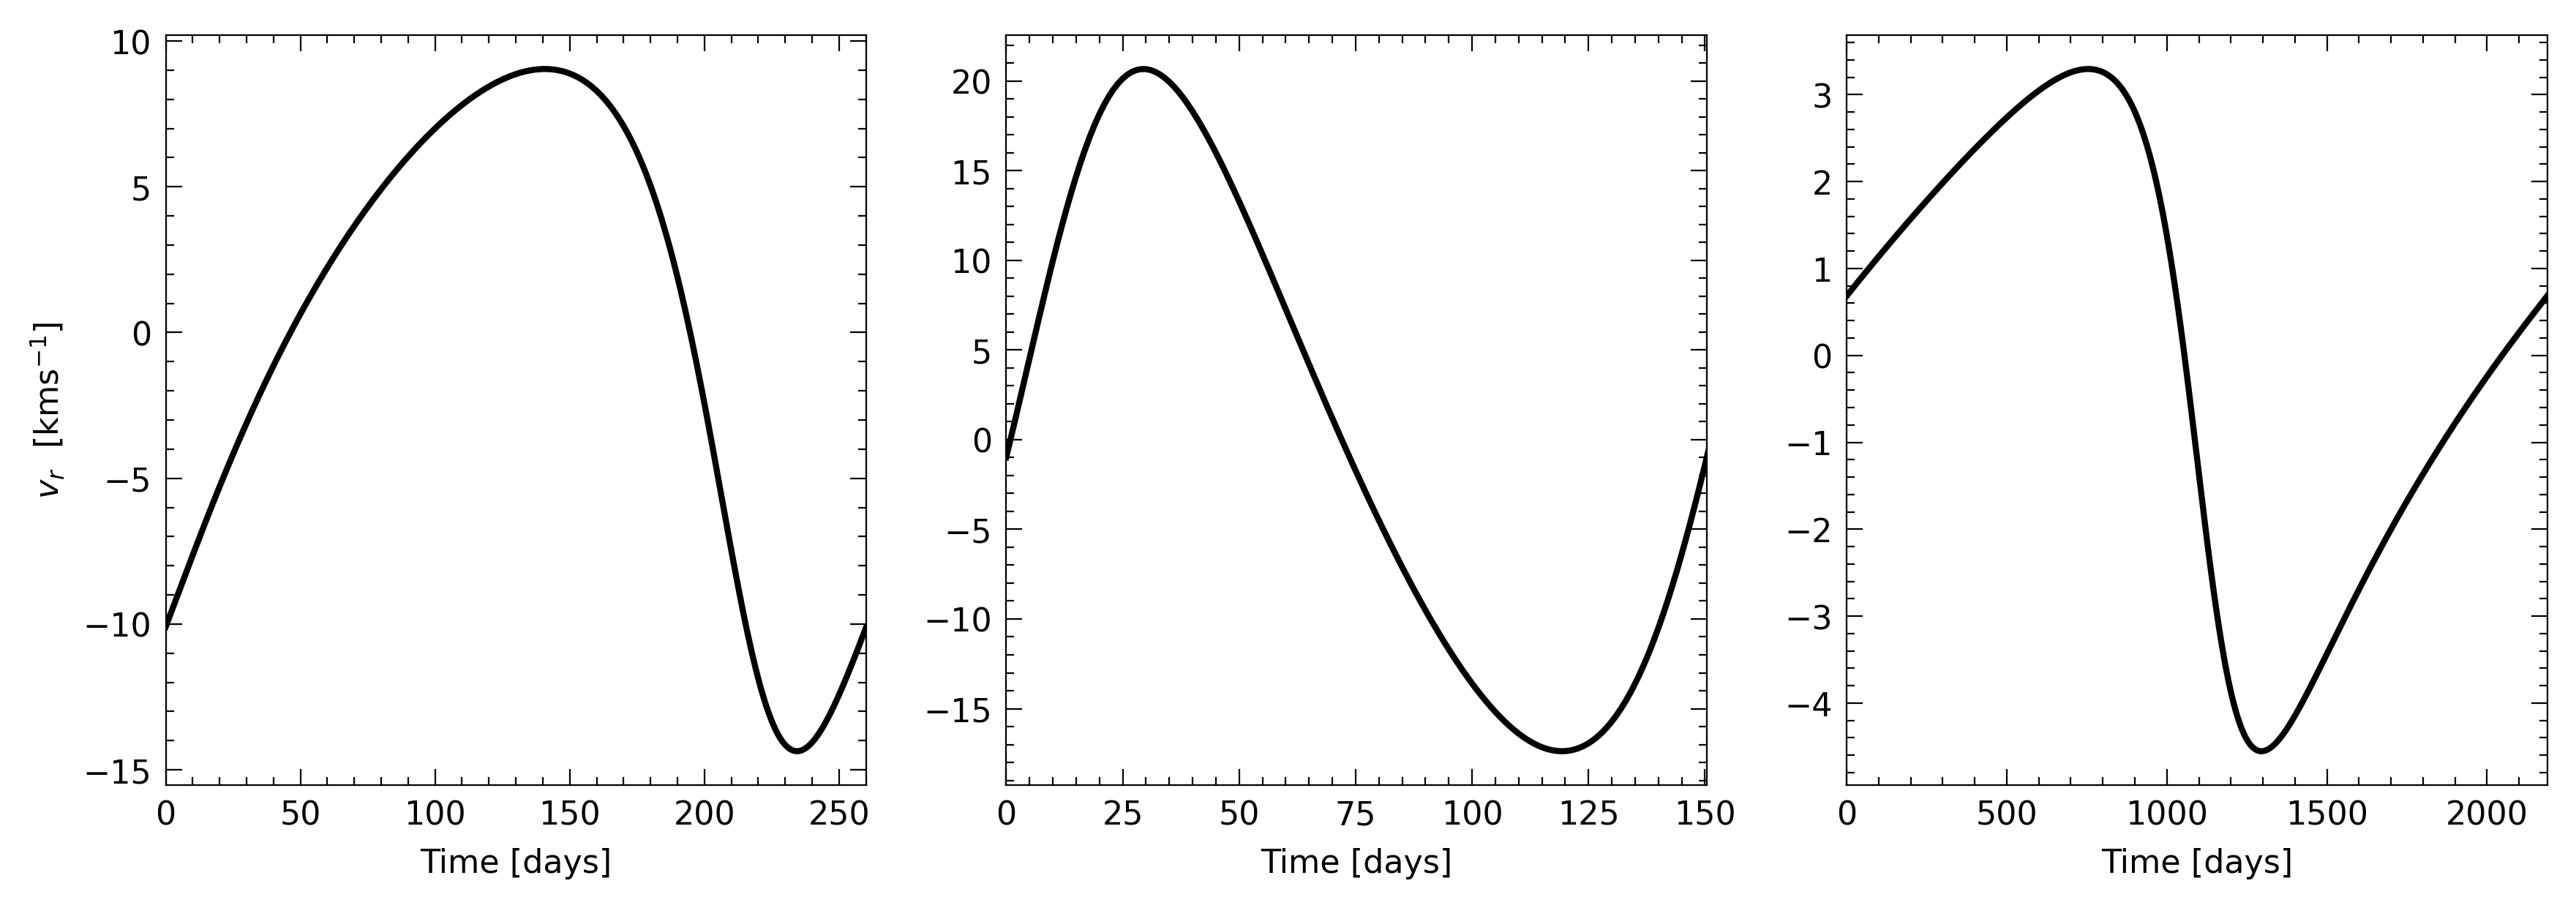

In [286]:
fig, axes = plt.subplots(1, 3, figsize=(3*3.5, 3.33))
t_total = dt * num_epochs
t_range = np.linspace(0, t_total, num_epochs)
axes[0].plot(t_range, vr[0], c='k')
axes[0].set_xlim(0,10**state.params.logP[0])
axes[1].plot(t_range, vr[5], c='k')
axes[1].set_xlim(0,10**state.params.logP[5])
axes[2].plot(t_range, vr[10], c='k')
axes[2].set_xlim(0,10**state.params.logP[10])

axes[0].set_ylabel(r'$v_r~~[\mathrm{km s^{-1}}]$')

axes[0].set_xlabel(r'Time [days]')
axes[1].set_xlabel(r'Time [days]')
axes[2].set_xlabel(r'Time [days]')
plt.show()